In [1]:
import os, sys
from shutil import copyfile
from datetime import datetime
import importlib
import skimage

In [2]:
import fastai
from fastai.vision.all import *
from fastai.basics import *
from torch.utils.tensorboard import SummaryWriter
from fastai.callback.fp16 import ModelToHalf
from fastai.callback.hook import hook_output
import tensorboard

In [3]:
sys.path.append(".")

from tensorboard_helpers import TensorBoardBaseCallback, TensorBoardCallback

In [4]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")

In [5]:
path = Path(ml_data_path)

oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [6]:
import skimage.io as skio
import numpy as np
import dask

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
lazy_results = []
for i in list(labels.glob("*.png"))[0:100]:
    arr = skio.imread(i)
    values = np.unique(arr)
    arr[arr==3] = 0
    try:
        lazy_result = dask.delayed(skio.imsave)(labels_no_3 / i.name, arr, check_contrast=False)
        lazy_results.append(lazy_result)
    except:
        continue
computed_results = dask.compute(*lazy_results)

In [7]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

473

In [8]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [21]:
MixedPrecision??

Init signature:
MixedPrecision(
    init_scale=65536.0,
    growth_factor=2.0,
    backoff_factor=0.5,
    growth_interval=2000,
    enabled=True,
)
Source:        
@delegates(GradScaler)
class MixedPrecision(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    order = 10
    def __init__(self, **kwargs): self.kwargs = kwargs
    def before_fit(self):
        self.autocast,self.learn.scaler,self.scales = autocast(),GradScaler(**self.kwargs),L()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self):
        if next(flatten(self.pred)).dtype==torch.float16: self.learn.pred = to_float(self.pred)
    def after_loss(self): self.autocast.__exit__(None, None, None)
    def before_backward(self): self.learn.loss_grad = self.scaler.scale(self.loss_grad)
    def before_step(self):
        self.skipped=True
        self.scaler.step(self)
        if self.skipped: raise CancelStepException()
        self.scales.append(self.scaler.get_sca

In [9]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
lcl =  Path('/root/data/experiments/cv1/'+timestampStr+'/')
#lcl = Path("../out_data")
lcl.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [10]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

In [11]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [12]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
seg_db.summary(path)

Setting-up type transforms pipelines
Found 473 items
2 datasets of sizes 369,104
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_lbls -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/data/cv1_transfer/labeled_data/chp/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: get_lbls -> PILBase.create
    starting from
      /root/data/cv1_transfer/labeled_data/chp/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying get_lbls gives
      /root/data/cv1_transfer/labeled_data/lbl_no3/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying PILBase.create gives
      PILMask mode=L size=512x512

Final sample: (PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)


Found 473 items
2 datasets of sizes 369,104
Setting up Pipeline: PILBase.create
Setting up Pipeline

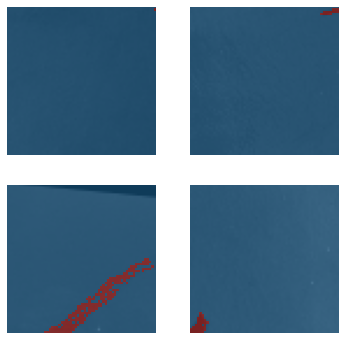

In [14]:
dls.show_batch(vmin=0, vmax=3)

In [15]:
# add best model callback saver
# write to drive not lcl

In [16]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [20]:
Dice??

Init signature: Dice(axis=1)
Source:        
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None
File:           ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py
Type:           type
Subclasses:     JaccardCoeff


In [ ]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

In [ ]:
lr = learn.lr_find()

In [ ]:
lr

In [ ]:
cbs = [TensorBoardCallback(projector=False, trace_model=False)]


In [ ]:
learn.fine_tune(5, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [ ]:
# learn.load("model")

In [ ]:
learn

In [ ]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(f'{modelpath}/{savename}')

In [ ]:
ls {modelpath}

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="/root/data/experiments/cv1/09_Mar_2022_18_32_17/tensorboard"
